# ETH/USD vs RAI/ETH Modeling
## Purpose
Determine the behavior of RAI/ETH

In [1]:
import time
import math
import pandas as pd
import numpy as np
import requests
import json
import multiprocess
from multiprocess import Pool
from decimal import Decimal
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.preprocessing import PowerTransformer
from sklearn import mixture

from scipy.stats import multivariate_normal
from web3 import Web3, HTTPProvider

import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

from uniswap import get_input_price, get_output_price, buy_to_price
from graph_util import fetch_safes, fetch_rp, fetch_debt_ceiling, fetch_saviour_safes
from web3_util import fetch_saviour_targets
from util import chunks

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

#### Create two ETH/USD, RAI/ETH datasets

1) Uniswap V2 RAI/ETH only: 3/01/21 - 5/01/21
1) Uniswap V2 RAI/ETH + V3 pools: 5/01/21 - 10/01/21

In [3]:
# Data from  3/1/21-5/1/21
# RAI/ETH V2 was the only liquidity pool
df_eth = pd.read_csv('eth_usd_cg.csv')
df_rai = pd.read_csv('rai_eth_influx.csv')

# Data from  5/1/21-10/1/21
# RAI/ETH V2 and V3 pools
df_eth2 = pd.read_csv('../twap/eth_usd.csv')
df_rai2 = pd.read_csv('../twap/rai_eth.csv')


Prep data: rename and drop columns

In [4]:
df_rai = df_rai.rename(columns={"value": "rai_eth"})
df_eth = df_eth.rename(columns={"value": "eth_usd"})
df_rai2 = df_rai2.rename(columns={"value": "rai_eth"})
df_eth2 = df_eth2.rename(columns={"value": "eth_usd"})
df_eth2 = df_eth2.drop('field', axis=1)
df_rai2 = df_rai2.drop('field', axis=1)

In [5]:
df_eth.head(3)

,time,eth_usd
0,2021-03-01T23:38:26Z,1561.05
1,2021-03-01T23:40:28Z,1561.05
2,2021-03-01T23:42:31Z,1560.38


In [6]:
df_eth2.head(3)

,time,eth_usd
0,2021-05-28T00:01:27Z,2742.99
1,2021-05-28T00:03:30Z,2742.92
2,2021-05-28T00:05:32Z,2742.92


In [7]:
df_rai.head(3)

,time,rai_eth
0,2021-03-01T23:39:09Z,0.002087
1,2021-03-01T23:40:03Z,0.002087
2,2021-03-01T23:44:05Z,0.002087


In [8]:
df_rai2.head(3)

,time,rai_eth
0,2021-05-28T00:03:02Z,0.001096
1,2021-05-28T00:05:14Z,0.001100
2,2021-05-28T00:21:06Z,0.001100


Prep data: parse time and round to nearest minute

In [9]:
df_rai['time'] = pd.to_datetime(df_rai['time'], infer_datetime_format=True)
df_eth['time'] = pd.to_datetime(df_eth['time'], infer_datetime_format=True)

df_rai2['time'] = pd.to_datetime(df_rai2['time'], infer_datetime_format=True)
df_eth2['time'] = pd.to_datetime(df_eth2['time'], infer_datetime_format=True)

In [10]:
df_rai['time_1m'] = df_rai['time'].dt.round('1min') 
df_eth['time_1m'] = df_eth['time'].dt.round('1min') 
df_rai = df_rai.drop_duplicates(['time_1m']) 
df_eth = df_eth.drop_duplicates(['time_1m']) 

df_rai2['time_1m'] = df_rai2['time'].dt.round('1min') 
df_eth2['time_1m'] = df_eth2['time'].dt.round('1min') 
df_rai2 = df_rai2.drop_duplicates(['time_1m']) 
df_eth2 = df_eth2.drop_duplicates(['time_1m']) 

Prep Data: Set time index and forward fill to every minute

In [11]:
df_rai = df_rai.set_index('time_1m')
df_rai = df_rai.asfreq('1min', method='ffill')
df_eth = df_eth.set_index('time_1m')
df_eth = df_eth.asfreq('1min', method='ffill')


df_rai2 = df_rai2.set_index('time_1m')
df_rai2 = df_rai2.asfreq('1min', method='ffill')
df_eth2 = df_eth2.set_index('time_1m')
df_eth2 = df_eth2.asfreq('1min', method='ffill')

Merge eth/usd and rai/eth data

In [12]:
df = pd.merge(df_rai['rai_eth'], df_eth['eth_usd'], left_index=True, right_index=True)
df2 = pd.merge(df_rai2['rai_eth'], df_eth2['eth_usd'], left_index=True, right_index=True)

Create hourly pct-change dataset

In [13]:
df_1H = df.resample('1H').first()[['rai_eth', 'eth_usd']]
df_1H_return = (df_1H.pct_change()+1).dropna()

df_1H2 = df2.resample('1H').first()[['rai_eth', 'eth_usd']]
df_1H_return2 = (df_1H2.pct_change()+1).dropna()

Plot ETH/USD and RAI/ETH prices for both datasets

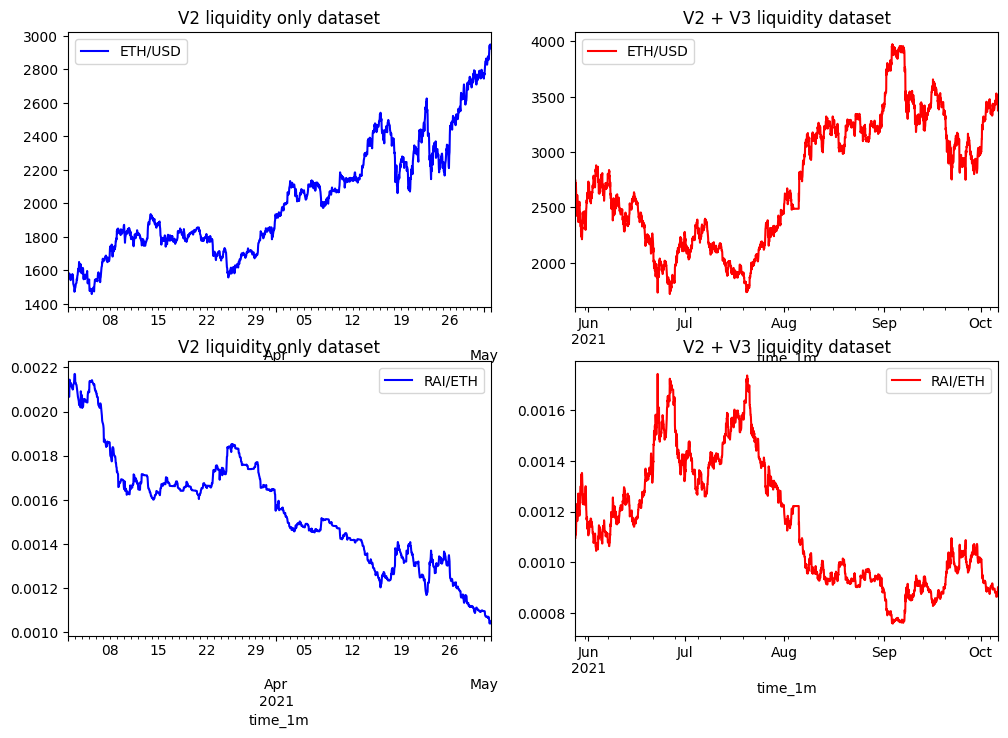

In [14]:
f, ax = plt.subplots(2, 2)

# ETH/USD prices
df_1H['eth_usd'].plot(ax=ax[0][0], color='blue', label='ETH/USD')
ax[0][0].set_title('V2 liquidity only dataset')
ax[0][0].legend(loc='upper left')
df_1H2['eth_usd'].plot(ax=ax[0][1], color='red', label='ETH/USD')
ax[0][1].set_title('V2 + V3 liquidity dataset')
ax[0][1].legend(loc='upper left')

# RAI/ETH prices
df_1H['rai_eth'].plot(ax=ax[1][0], color='blue', label='RAI/ETH')
ax[1][0].set_title('V2 liquidity only dataset')
ax[1][0].legend()

# RAI/ETH prices
df_1H2['rai_eth'].plot(ax=ax[1][1], color='red', label='RAI/ETH')
ax[1][1].set_title('V2 + V3 liquidity dataset')
ax[1][1].legend()

#plt.tight_layout()
plt.legend()
plt.show()

Scatter plots of eth/usd returns vs rai/eth returns

Text(0.5, 1.0, 'V2 + V3 liquidity dataset')

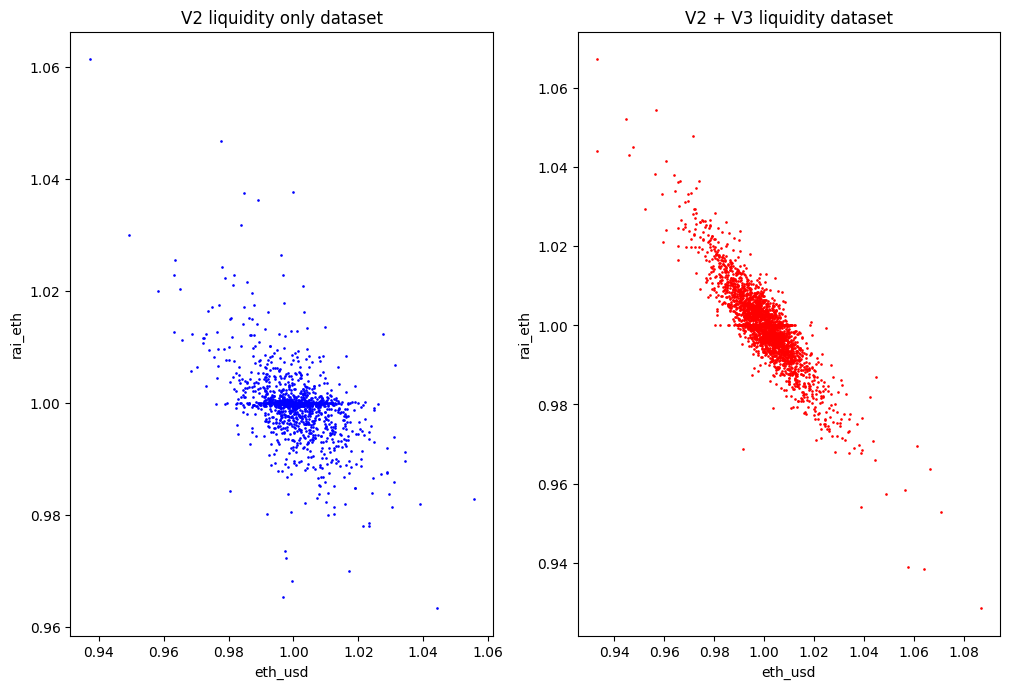

In [15]:
f, ax = plt.subplots(1, 2)
df_1H_return.plot.scatter('eth_usd', 'rai_eth', 0.8, color='blue', ax=ax[0])
ax[0].set_title('V2 liquidity only dataset')
#ax[0].legend(loc='upper right')
df_1H_return2.plot.scatter('eth_usd', 'rai_eth', 0.8, color='red', ax=ax[1])
ax[1].set_title('V2 + V3 liquidity dataset')
#ax[1].legend(loc='upper right')


[0.98063716]


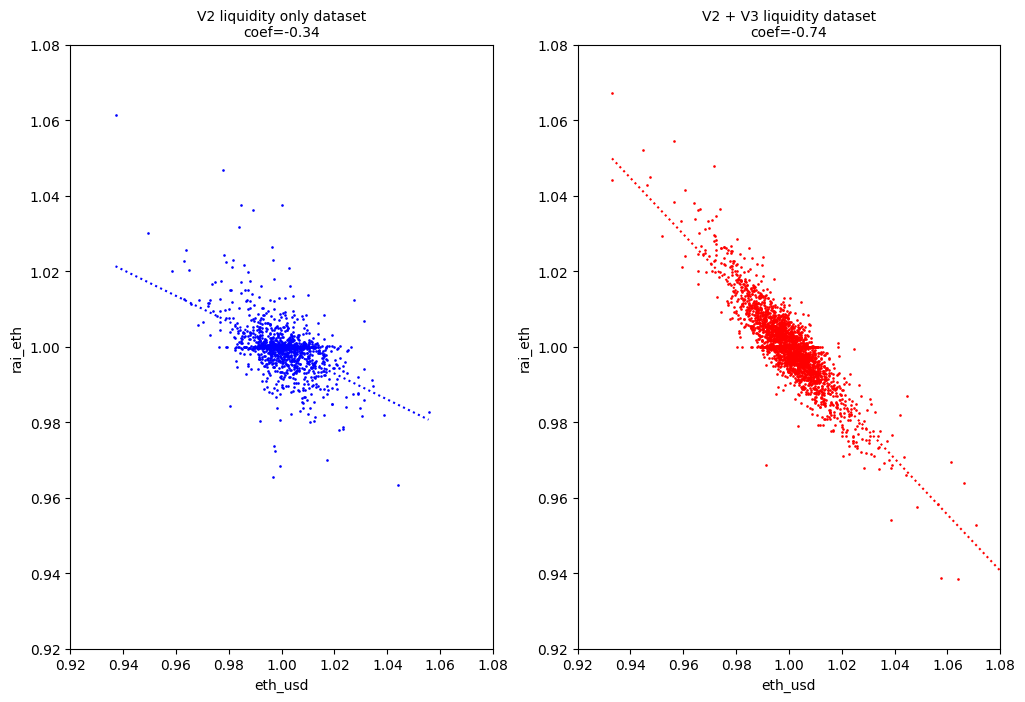

In [16]:
from sklearn import linear_model

reg = linear_model.LinearRegression().fit(df_1H_return['eth_usd'].values.reshape(-1,1),\
                                   df_1H_return['rai_eth'].values.reshape(-1,1))

reg.intercept_, reg.coef_


reg2 = linear_model.LinearRegression().fit(df_1H_return2['eth_usd'].values.reshape(-1,1),\
                                    df_1H_return2['rai_eth'].values.reshape(-1,1))

f, ax = plt.subplots(1, 2)

df_1H_return.plot.scatter('eth_usd', 'rai_eth', 0.8, color='blue', ax=ax[0])
df_1H_return2.plot.scatter('eth_usd', 'rai_eth', 0.8, color='red', ax=ax[1])

x = np.linspace(min(df_1H_return['eth_usd']), max(df_1H_return['eth_usd']), 100)
y = (x * reg.coef_ + reg.intercept_).reshape(-1,1)
ax[0].plot(x.reshape(-1,1), y, ':', 0.8, color='blue')
ax[0].set_title(f"V2 liquidity only dataset\ncoef={reg.coef_[0][0]:.2f}", fontsize=10)
ax[0].set_xlim([0.92, 1.08])
ax[0].set_ylim([0.92, 1.08])

x2 = np.linspace(min(df_1H_return2['eth_usd']), max(df_1H_return2['eth_usd']), 100)
y2 = (x2*reg2.coef_ + reg2.intercept_).reshape(-1,1)
ax[1].plot(x2.reshape(-1,1), y2, ':', color='red')
ax[1].set_title(f"V2 + V3 liquidity dataset\ncoef={reg2.coef_[0][0]:.2f}", fontsize=10)
ax[1].set_xlim([0.92, 1.08])
ax[1].set_ylim([0.92, 1.08])
print(min(y))

In [17]:
min(df_1H_return['rai_eth'])

0.9633538250346493

In [18]:
# Create a Gaussian Mixture Model with one component from Uni V2-only data
gmm = mixture.GaussianMixture(n_components=1, covariance_type='full')
gmm.fit(df_1H_return[['rai_eth', 'eth_usd']])

gmm2 = mixture.GaussianMixture(n_components=1, covariance_type='full')
gmm2.fit(df_1H_return2[['rai_eth', 'eth_usd']])

GaussianMixture()

In [19]:
covs = gmm.covariances_
means = gmm.means_

# can use these later to generate samples in simulation
print(means)
print(covs)

[[0.99954459 1.00047911]]
[[[ 4.13783784e-05 -3.19083822e-05]
  [-3.19083822e-05  9.39901212e-05]]]


/var/folders/z_/tzvx3mfs7rsbb8dxt0rd157w0000gn/T/ipykernel_38026/434901081.py:11: UserWarning: Log scale: values of z <= 0 have been masked
  CS = plt.contour(X, Y, Z,
/var/folders/z_/tzvx3mfs7rsbb8dxt0rd157w0000gn/T/ipykernel_38026/434901081.py:15: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  CB = plt.colorbar(CS, shrink=0.8, extend='both')


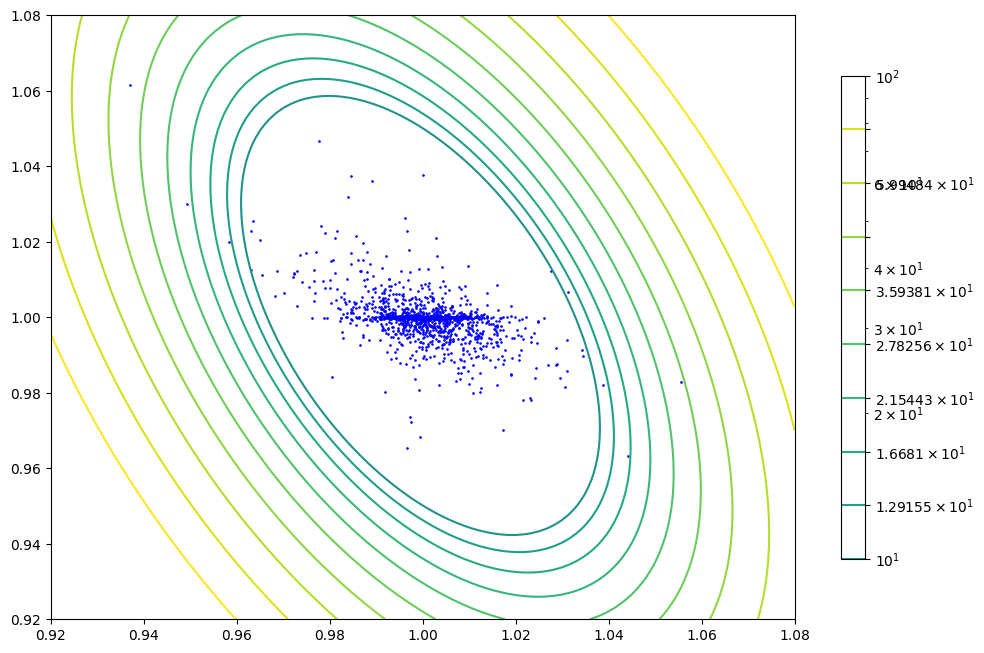

In [20]:
from matplotlib.colors import LogNorm

# display predicted scores by the model as a contour plot
x = np.linspace(0.92, 1.08, 100)
y = np.linspace(0.92, 1.08, 100)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, 
                 norm=LogNorm(vmin=1.0, vmax=100.0),
                 levels=np.logspace(1, 2, 10))

CB = plt.colorbar(CS, shrink=0.8, extend='both')

plt.scatter(df_1H_return['eth_usd'].values.reshape(-1,1), df_1H_return['rai_eth'].values.reshape(-1,1), .8, color='blue')

#plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
#plt.xlabel('Title', fontsize=16)
#plt.ylabel('C-ratio', fontsize=16)
plt.show()

In [21]:
def cond_dist(means, covs, a):
    # distribution of x1 given x2=a
    # distribution of rai_eth return given an eth_usd return
    # Reference: https://online.stat.psu.edu/stat505/lesson/6/6.1
    mu_1, mu_2 = means[0]
    cov_11 = covs[0][0, 0]
    cov_12 = covs[0][0, 1]
    cov_21 = covs[0][1, 0]
    cov_22 = covs[0][1, 1]
    
    mu_cond = mu_1 + cov_12 * (1/cov_22) * (a - mu_2)
    cov_cond = cov_11 - cov_12 * (1/cov_22) * cov_21
    
    return mu_cond, cov_cond

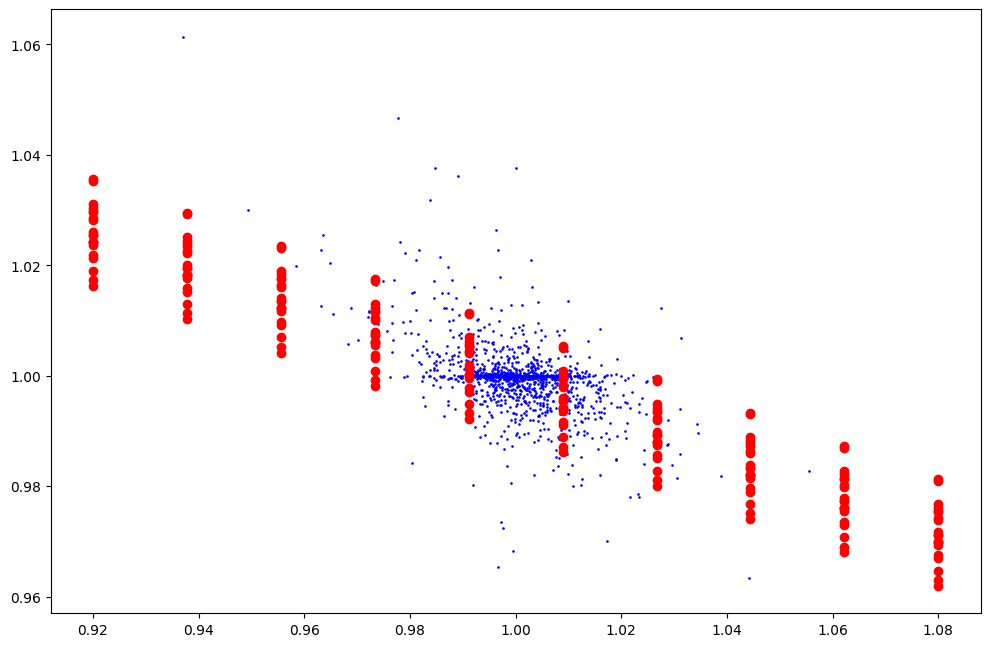

In [34]:
#df_1H_return.plot.scatter('rai_eth', 'eth_usd', color='orange')
plt.scatter(df_1H_return['eth_usd'].values.reshape(-1,1), 
            df_1H_return['rai_eth'].values.reshape(-1,1), .8, color='blue')

for eth_return in np.linspace(0.92, 1.08, 10):
    mu_cond, cov_cond = cond_dist(means, covs, eth_return)
    samples = multivariate_normal.rvs(mu_cond, cov_cond*1, size=20, random_state=42)
    #print(f"{samples=}")
    
    plt.scatter([eth_return] * len(samples), samples, color='red')
    #plt.xlim([-0.08, 0.08])
    #plt.ylim([0.92, 1.08])